In [1]:
##5月6号
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import math
import os
from shapely.geometry import Point,Polygon,shape
from shapely.geometry import LineString
##全显示不折叠，非常耗内存，非特殊情况不要生效
#pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

In [2]:
##合并老卡和新卡的6号的数据
allshuka=pd.concat(map(pd.read_csv,[r'D:\项目\扬州\公交刷卡数据\老卡时间修正5月13号.csv',r'D:\项目\扬州\公交刷卡数据\新卡不必时间修正5月13日.csv']))
allshuka.to_csv(r'D:\项目\扬州\公交刷卡数据\新旧卡所有刷卡5月13日.csv')  
allshuka

,Unnamed: 0,CHEID,日期,时间
0,0,4879.0,20210513,10:45:30
1,1,4879.0,20210513,10:51:13
2,2,4879.0,20210513,11:1:29
3,3,4879.0,20210513,11:4:8
4,4,4879.0,20210513,11:10:17
...,...,...,...,...
96839,96839,4152.0,20210513,17:48:19
96840,96840,4152.0,20210513,18:19:48
96841,96841,4152.0,20210513,17:13:19
96842,96842,4152.0,20210513,17:13:18


In [3]:
#allshuka=pd.read_csv(r'D:\项目\扬州\公交刷卡数据\新旧卡所有刷卡5月6日.csv')
allshuka.时间 = allshuka.时间 .apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                allshuka.时间 .apply(lambda r:r.split(':')[1]).astype('int')*60+\
               allshuka.时间 .apply(lambda r:r.split(':')[2]).astype('int')
#allshuka

In [4]:
allshuka

,Unnamed: 0,CHEID,日期,时间
0,0,4879.0,20210513,38730
1,1,4879.0,20210513,39073
2,2,4879.0,20210513,39689
3,3,4879.0,20210513,39848
4,4,4879.0,20210513,40217
...,...,...,...,...
96839,96839,4152.0,20210513,64099
96840,96840,4152.0,20210513,65988
96841,96841,4152.0,20210513,61999
96842,96842,4152.0,20210513,61998


In [5]:
allxianlu=pd.read_excel(r'F:\扬州公交GPS数据\ic线路对应2021-11-25.xls')
allxianlu

,序号,IC线路号,线路id,线路名称,说明,5月6日匹配结果（车次编号*趟数）,上行方向
0,3,10,1001,1路,NaN,19*8,东向西
1,4,20,1002,2路,NaN,NaN,北向南
2,5,30,1003,3路,NaN,NaN,NaN
3,6,50,1005,5路,NaN,NaN,北向南
4,7,60,1006,6路,NaN,NaN,北向南
...,...,...,...,...,...,...,...
207,158,9980,3088,K1路,NaN,NaN,NaN
208,161,883,3088,K1路,NaN,NaN,NaN
209,203,9880,3088,K1路,NaN,NaN,NaN
210,204,1032,3103,103区间车,NaN,NaN,NaN


In [36]:
allxianlu2=allxianlu.iloc[186:190]
allxianlu2

,序号,IC线路号,线路id,线路名称,说明,5月6日匹配结果（车次编号*趟数）,上行方向
186,186,11,2001,1路晚,NaN,NaN,NaN
187,187,81,2008,8路晚,NaN,NaN,NaN
188,188,181,2018,18路晚,NaN,NaN,NaN
189,189,201,2020,20路晚,NaN,NaN,NaN


In [37]:
for idid in range(0,len(allxianlu2)):
    routeid=allxianlu2['线路id'].iloc[idid]
    xianluname=allxianlu2['线路名称'].iloc[idid]
    ####读取同一条线路上的车
    import glob
    ##母文件夹地址和文件类型
    files=glob.glob(r'D:\项目\扬州\BUSGPS\车辆编号带线路编号///*'+'_'+str(routeid)+'.csv')###!!!!
    ##需要读取的列
    #cols=['ROUTEID']
    ##列表推导出对象
    #dflist=[pd.read_csv(i,usecols=cols) for i in files]
    files = gpd.GeoDataFrame(files)#
    #print(files )
    files.columns=['文件']
    files['文件']= files['文件'].astype(str)
    for i in range(0,len(files)):
        files.at[i,'文件']=str(files.at[i,'文件']).replace('\\','B')
        files.at[i,'文件']=str(files.at[i,'文件']).replace(r'D:B项目B扬州BBUSGPSB车辆编号带线路编号B','')
        files.at[i,'文件']=str(files.at[i,'文件']).replace(r'_'+str(routeid)+'.csv','')##前面后面分开替换成无，注意要用r和双斜杠
    #读取公交线数据，方式二
    shp = r'D:\项目\扬州\公交线路\公交线路\公交线路（地理坐标）.shp'
    xianlu= geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
    ###line数据预处理
    xianlu = gpd.GeoDataFrame(xianlu)##转换为一个GeoDataFrame
    ###GeoDataFrame坐标转换
    xianlu.crs = {'init':'epsg:4326'}
    xianlu = xianlu.to_crs(epsg = 2416)
    xianlu###至此线路数据预处理完毕
    #print(xianluname)
    xianluid=routeid
    #读取公交线数据方式一
    #if xianluid > 2000:
        #xianluid2=xianluid-1000
        #print(xianluid2)
    #elif xianluid > 3000:
        #xianluid2=xianluid-2000
        #print(xianluid2)
    #else:
        #xianluid2=xianluid
        #print(xianluid2)
    #lineshp=xianlu.loc[xianlu.ROUTEID==xianluid2]###这种索引方式更舒适一些
    lineshp=xianlu.loc[xianlu.busID==xianluname]
    lineshp=lineshp['geometry'].iloc[0]
    ##匹配上下客人数
    #cheid3=cheid2
    ##根据图形，选择cheid2
    for cheid in files['文件']:
        #读取GPS数据
        BUS_GPS= pd.read_csv(r'D:\项目\扬州\BUSGPS\车辆编号带线路编号\\'+str(cheid)+'_'+str(routeid)+'.csv',header = None)
        #print('len(BUS_GPS)')
        #print(len(BUS_GPS))
        if len(BUS_GPS)>1000:
            ##提取有用BUS_GPS
            BUS_GPS.columns=BUS_GPS.iloc[0]
            BUS_GPS=BUS_GPS[BUS_GPS['???"BUSRDID"']!='???"BUSRDID"']
            BUS_GPS=BUS_GPS[[ '???"BUSRDID"', 'ROUTEID', 'PRODUCTID', 'ACTDATETIME', 'BUSSID', 'LONGITUDE', 'LATITUDE']]
            ###切分字符串，对BUS_GPS进行进一步处理
            #print(BUS_GPS)
            BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/12']
            BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/13']
            BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/14']
            BUS_GPS['日期'] = BUS_GPS['ACTDATETIME'].apply(lambda r:r.split(' ')[0])
            BUS_GPS['时间'] = BUS_GPS['ACTDATETIME'].apply(lambda r:r.split(' ')[1])
            BUS_GPS=BUS_GPS.loc[BUS_GPS.日期=='2021/5/13']
            if len(BUS_GPS)>100:
                ##切分bus_gps的车辆编号
                BUS_GPS['PRODUCTID']= BUS_GPS['PRODUCTID'].astype(str)
                BUS_GPS['carid'] = BUS_GPS['PRODUCTID'].apply(lambda r:r.split('5140')[1])
                BUS_GPS['time_st'] = BUS_GPS['时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                                BUS_GPS['时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                                BUS_GPS['时间'].apply(lambda r:r.split(':')[2]).astype('int')
                BUS_GPS.sort_values(by='time_st',inplace=True)
                ##BUS_GPS[BUS_GPS['BUSSID']=='4.0']观察数据，bussid 4下行5上行6环形
                ###生成BUS_GPS的点要素
                #对公交GPS点生成点要素，并转换为一个GeoDataFrame，方便后续的地图匹配
                BUS_GPS[['ROUTEID','LONGITUDE','LATITUDE']]= BUS_GPS[['ROUTEID','LONGITUDE','LATITUDE']].apply(pd.to_numeric)###字符串转换为数值
                BUS_GPS['geometry'] = BUS_GPS.apply(lambda r:Point(r['LONGITUDE'],r['LATITUDE']),axis = 1)
                BUS_GPS = gpd.GeoDataFrame(BUS_GPS)##转换为一个GeoDataFrame
                BUS_GPS
                xianluid=BUS_GPS['ROUTEID'].iloc[0]
                #print('xianluid')
                #print(xianluid)
                ##GeoDataFrame坐标转换
                BUS_GPS.crs = {'init':'epsg:4326'}
                BUS_GPS = BUS_GPS.to_crs(epsg = 2416)
                BUS_GPS###至此公交车数据预处理完毕
                ###清除飘零点
                BUS_GPS=BUS_GPS[(BUS_GPS['LONGITUDE']!=0)&(BUS_GPS['LATITUDE']!=0)]
                if len(BUS_GPS)>1000:
                    #地图匹配
                    BUS_GPS['project'] = BUS_GPS['geometry'].apply(lambda r:lineshp.project(r))
                    #原始的坐标点存储在一个字段中
                    BUS_GPS['geometry_orgin'] = BUS_GPS['geometry']
                    #生成匹配的坐标点
                    BUS_GPS['geometry'] = BUS_GPS['project'].apply(lambda r:lineshp.interpolate(r))
                    #批量计算原始点和匹配点之间的距离
                    BUS_GPS['diff'] = BUS_GPS.apply(lambda r:r['geometry_orgin'].distance(r['geometry']),axis = 1)
                    ##轨迹点偏移shp400米以外，则删除
                    BUS_GPS=BUS_GPS[BUS_GPS['diff']<400]
                    if len(BUS_GPS)>1000:
                        ###区别车辆的上下行
                        #对车辆重新编号
                        BUS_GPS=BUS_GPS.loc[(BUS_GPS.BUSSID=='4.0')|(BUS_GPS.BUSSID=='5.0')]
                        BUS_GPS['BUSSID1'] = BUS_GPS['BUSSID'].shift()
                        #此时两个条件：方向发生了改变或者本来这一条记录就是新车
                        BUS_GPS['flag'] = BUS_GPS['BUSSID1']!=BUS_GPS['BUSSID']
                        BUS_GPS['changedir'] = BUS_GPS['flag'].cumsum()
                        #提取有用的信息列
                        BUS_project = BUS_GPS[['carid','changedir','time_st','project','BUSSID']]
                        BUS_project = BUS_project.drop_duplicates()
                        #print(BUS_project)
                            ##提取线路上的站点
                        allstop=gpd.read_file(r'D:\项目\扬州\BUSGPS\ROUTESTATION.csv',encoding = 'utf-8')
                        mytest=allstop.loc[allstop.ROUTEID==str(xianluid)]
                        mytest=mytest.filter(items=['???RSEGMENTSID', 'ROUTEID', 'SEGMENTID', 'STATIONID',
                               'SNGSERIALID', 'STATIONTYPEID', 'STATIONTYPENAME', 'DUALSERIALID', 'STATIONNAME'])
                        mytest[['SEGMENTID','SNGSERIALID','DUALSERIALID']]= mytest[['SEGMENTID','SNGSERIALID','DUALSERIALID']].apply(pd.to_numeric)
                        mytest.sort_values(by=['SEGMENTID','SNGSERIALID','DUALSERIALID'],inplace=True)##要转化数据格式，不然是按照字符串正则排序
                        stations=mytest['STATIONID']
                        ##获取站点的具体信息
                        STATION= gpd.read_file(r'D:\项目\扬州\BUSGPS\STATION.csv',encoding = 'utf-8')
                        test=STATION.filter(items=['???STATIONID', 'STATIONNO', 'STATIONNAME', 'STATIONTYPE',
                               'STATIONTYPENAME', 'ROADNAME', 'LONGITUDE','LATITUDE'])
                        mystation=test[test['???STATIONID'].isin(stations)]
                        ##合并信息
                        st=mytest.merge(mystation,how='outer',left_on='STATIONID',right_on='???STATIONID',left_index=False,right_index=False,sort=False,suffixes=('_linestation', '_station'),copy=True,indicator=False,validate=None)
                        ##生成站点的点要素
                        stop=st[['ROUTEID', 'SEGMENTID', 'STATIONID', 'SNGSERIALID', 'STATIONTYPEID',  'DUALSERIALID','STATIONNAME_linestation', 'STATIONNO',
                         'STATIONTYPE','ROADNAME', 'LONGITUDE', 'LATITUDE']]
                        stop.columns=['ROUTEID', '上下行标记', 'STATIONID', '单程站序', 'STATIONTYPEID',  '往返站序','STATIONNAME', 'STATIONNO',
                         'STATIONTYPE','ROADNAME', 'LONGITUDE', 'LATITUDE']
                        stop[['LONGITUDE','LATITUDE']]= stop[['LONGITUDE','LATITUDE']].apply(pd.to_numeric)###字符串转换为数值
                        #print(stop)
                        stop=stop.dropna()
                        stop['geometry'] = stop.apply(lambda r:Point(r['LONGITUDE'],r['LATITUDE']),axis = 1)
                        stop = gpd.GeoDataFrame(stop)##转换为一个GeoDataFrame
                        ###GeoDataFrame坐标转换
                        stop.crs = {'init':'epsg:4326'}
                        stop = stop.to_crs(epsg = 2416)
                        stop=stop[(stop['LONGITUDE']!=0)&(stop['LATITUDE']!=0)]
                        #print(stop)
                        ###至此站点数据预处理完毕
                        #标记站点位置
                        #地图匹配
                        stop['project'] = stop['geometry'].apply(lambda r:lineshp.project(r))
                        #stop = stop[stop['linename'] == linename]
                        ##上行到离站识别
                        #stop=stopall.loc[stopall.上下行标记==sxzhandian[0]]
                        #BUS_project=BUS_projectall.loc[(BUS_projectall.BUSSID!='5.0')|(BUS_projectall.BUSSID!='5')]
                        ##到离站时间识别
                        #定义时间阈值
                        mintime =10*60
                        from shapely.geometry import LineString,Polygon
                        import shapely
                        #定义一个空的list存储识别结果
                        ls = []
                        #对每一辆车识别
                        for car in BUS_project['carid'].drop_duplicates():
                            #提取车辆轨迹
                            tmp = BUS_project[BUS_project['carid'] == car]
                            #print('tmp')
                            #print(tmp)
                            #对每一个站点识别
                            for stopid in stop['STATIONNO'].drop_duplicates():
                                try:
                                    ##提取站点名称
                                    stopname = stop[stop['STATIONNO'] == stopid]['STATIONNAME'].iloc[0]
                                    #提取站点位置
                                    position = stop[stop['STATIONNO'] == stopid]['project'].iloc[0]
                                    #做buffer缓冲区
                                    stopbuffer = 500
                                    #生成一个buffer的polygon
                                    buffer_polygon = LineString([[0,position],[24*3600,position]]).buffer(stopbuffer)
                                    #生成车辆轨迹的linestring
                                    bus_linestring = LineString(tmp[['time_st','project']].values)
                                    #提取车辆轨迹与buffer的交集
                                    line_intersection = bus_linestring.intersection(buffer_polygon)
                                    #从multilinestring中提取其中的到离站轨迹
                                    if type(line_intersection) == shapely.geometry.linestring.LineString:
                                        arrive = [line_intersection]
                                    else:
                                        arrive = list(line_intersection)
                                    arrive = pd.DataFrame(arrive)
                                    #取其中的到离站信息
                                    arrive['arrivetime']= arrive[0].apply(lambda r:r.coords[0][0])
                                    arrive['leavetime']= arrive[0].apply(lambda r:r.coords[-1][0])
                                    #print(arrive)
                                    #通过时间阈值筛选到离站信息
                                    a = arrive[['arrivetime']]
                                    a.columns = ['time']
                                    a['flag'] = 1
                                    b = arrive[['leavetime']]
                                    b.columns = ['time']
                                    b['flag'] = 0
                                    c = pd.concat([a,b]).sort_values(by = 'time')
                                    #print('len(c)前')
                                    #print(c)
                                    c['time1'] = c['time'].shift(-1)
                                    c['flag_1'] = ((c['time1']-c['time'])<mintime)&(c['flag']==0)
                                    c['flag_2'] = c['flag_1'].shift().fillna(False)
                                    c['flag_3'] = c['flag_1']|c['flag_2']
                                    c = c[-c['flag_3']]
                                    #print('len(c)后')
                                    #print(c)
                                    #重新整理到离站信息
                                    arrive_new = c[c['flag'] == 1][['time']]
                                    arrive_new.columns = ['arrivetime']
                                    arrive_new['leavetime'] = list(c[c['flag'] == 0]['time'])
                                    arrive_new['stopname'] = stopname
                                    arrive_new['stopID'] = stopid
                                    arrive_new['carid'] = car
                                    #合并数据
                                    ls.append(arrive_new)
                                except:
                                    pass
                        ##该线路上的这辆车的刷卡数据
                        kaocc=allshuka.loc[allshuka.CHEID==float(cheid)]
                        if (xianluid>2000) or xianluid==1028 :
                            kaocc=kaocc.loc[kaocc.时间>=64800-3600]
                        else:
                            kaocc=kaocc.loc[kaocc.时间<=64800+3600*2] 
                        #print('kaocc')
                        #print(len(kaocc))
                        if len(ls)==0:
                            print('到离站识别失败')
                        else:
                            #合成一个大表
                            ls = pd.concat(ls)
                            print('len(ls)')
                            print(len(ls))
                            #print(ls)
                            ##时间中值
                            ls['中间时间']=ls['arrivetime']*0.5+ls['leavetime']*0.5
                            ##匹配到每辆车
                            kaocc.sort_values('时间',inplace=True)
                            kaocc['站点1']=None
                            kaocc['站点编号1']=None
                            kaocc['中心距1']=None
                            for i in range(0,len(kaocc)):
                                for k in range(0,len(ls)):
                                    if kaocc.时间.iloc[i]<=ls.leavetime.iloc[k]:
                                         if kaocc.时间.iloc[i]>=ls.arrivetime.iloc[k]:
                                                ju=(kaocc.时间.iloc[i]-ls.中间时间.iloc[k])**2
                                                if kaocc['站点1'].iloc[i]!=None:
                                                    if ju<kaocc['中心距1'].iloc[i]:
                                                        kaocc['站点编号1'].iloc[i]=ls.stopID.iloc[k] 
                                                        kaocc['站点1'].iloc[i]=ls.stopname.iloc[k]
                                                        kaocc['中心距1'].iloc[i]=ju
                                                if kaocc['站点1'].iloc[i]==None:
                                                    kaocc['站点编号1'].iloc[i]=ls.stopID.iloc[k] 
                                                    kaocc['站点1'].iloc[i]=ls.stopname.iloc[k]
                                                    kaocc['中心距1'].iloc[i]=ju
                                if kaocc['站点1'].iloc[i]==None:
                                    kaocc['站点1'].iloc[i]='异常刷卡'  
                                    kaocc['站点编号1'].iloc[i]='异常刷卡' 
                            IDkaocc=kaocc[[ 'CHEID', '日期', '时间', '站点1','站点编号1']]
                            #print('IDkaocc')
                            #print(IDkaocc)
                            g=kaocc.loc[kaocc.站点1=='异常刷卡']
                            print('异常刷卡数量')
                            print(len(g))
                            IDkaocc.to_csv(r'D:\项目\扬州\公交刷卡数据\站点匹配完毕13\\'+str(cheid)+'_'+str(routeid)+'.csv')
                ##读取同一条线路上的车
    import glob
    ##母文件夹地址和文件类型
    files=glob.glob(r'D:\项目\扬州\公交刷卡数据\站点匹配完毕13///*'+'_'+str(routeid)+'.csv')
    ##需要读取的列
    cols=[ 'CHEID', '日期', '时间', '站点1','站点编号1']
    ##列表推导出对象
    dflist=[pd.read_csv(i,usecols=cols) for i in files]
    ##合并
    df=pd.concat(dflist)###会有重复表头，需要清除  
    df=df.loc[df.CHEID!='CHEID']
    df['刷卡']=1
    df['站点编号1']= df['站点编号1'].astype(str)
    df2=df.groupby(['站点1','站点编号1'])['刷卡'].sum().rename('站点上车人数').reset_index()##双向
    df2.to_excel(r'D:\项目\扬州\公交刷卡数据\上下车集计13\\'+str(routeid)+'.xlsx')
    print(routeid,df2,df2.站点上车人数.sum())###上车合计

len(ls)
246
异常刷卡数量
1
len(ls)
246
异常刷卡数量
32
len(ls)
246
异常刷卡数量
2
len(ls)
246
异常刷卡数量
7
len(ls)
246
异常刷卡数量
3
len(ls)
246
异常刷卡数量
30
len(ls)
248
异常刷卡数量
2
len(ls)
246
异常刷卡数量
45
len(ls)
248
异常刷卡数量
22
len(ls)
248
异常刷卡数量
7
len(ls)
248
异常刷卡数量
28
len(ls)
248
异常刷卡数量
25
2001              站点1   站点编号1  站点上车人数
0          七里河公园  101971       6
1          七里河公园  101973       8
2         亚联批发市场  127022       1
3            仙鹤寺  107721      12
4            仙鹤寺  107723      31
5             双桥  106412      14
6             双桥  106414       1
7           奥邦广场  107331       6
8           奥邦广场  107333       8
9            市人防  106191       5
10           市人防  106193      15
11        市委党校北门  106241       2
12     市委党校（市体校）  106222       8
13     市委党校（市体校）  106224       6
14          异常刷卡    异常刷卡     204
15           徐桥村  108072      15
16           徐桥村  108074       3
17          扬大师院  108221      20
18          扬大师院  108223      18
19        扬州友好医院  108452      20
20        扬州友好医院  108454       1
21         

In [ ]:

shp = r'D:\项目\扬州\公交线路\公交线路\公交线路（地理坐标）.shp'
xianlu= geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
###line数据预处理
xianlu = gpd.GeoDataFrame(xianlu)##转换为一个GeoDataFrame
###GeoDataFrame坐标转换
xianlu.crs = {'init':'epsg:4326'}
xianlu = xianlu.to_crs(epsg = 2416)
xianlu###至此线路数据预处理完毕
lineshp=xianlu.loc[xianlu.ROUTEID==xianluid2]###这种索引方式更舒适一些
lineshp=lineshp['geometry'].iloc[0]
lineshp

len(BUS_GPS)
2750
len(BUS_GPS)
3065
len(BUS_GPS)
7172
0    ???"BUSRDID"  ROUTEID PRODUCTID         ACTDATETIME BUSSID   LONGITUDE  \
3351  31117491230     2001  51402437   2021/5/13 9:01:34   16.0    0.000000   
3346  31117492105     2001  51402437   2021/5/13 9:01:39   16.0  119.335964   
3347  31117493089     2001  51402437   2021/5/13 9:01:44   16.0  119.335940   
3349  31117494393     2001  51402437   2021/5/13 9:01:49   16.0  119.335923   
3350  31117495255     2001  51402437   2021/5/13 9:01:54   16.0  119.335905   
...           ...      ...       ...                 ...    ...         ...   
6587  31129753470     2001  51402437  2021/5/13 22:10:10   16.0  119.335686   
6539  31129753658     2001  51402437  2021/5/13 22:10:15   16.0  119.335686   
6593  31129753907     2001  51402437  2021/5/13 22:10:20   16.0  119.335686   
6611  31129754093     2001  51402437  2021/5/13 22:10:25   16.0  119.335686   
6617  31129754284     2001  51402437  2021/5/13 22:10:30   16.0  119.335686  

len(BUS_GPS)
6946
0    ???"BUSRDID"  ROUTEID PRODUCTID         ACTDATETIME BUSSID   LONGITUDE  \
2945  31114376616     2001  51402446   2021/5/13 6:16:38   16.0    0.000000   
2946  31114377361     2001  51402446   2021/5/13 6:16:44   16.0  119.336456   
2947  31114378029     2001  51402446   2021/5/13 6:16:49   16.0  119.336470   
2948  31114378552     2001  51402446   2021/5/13 6:16:54   16.0  119.336471   
3031  31127752675     2001  51402446  2021/5/13 17:49:23    2.0  119.335612   
...           ...      ...       ...                 ...    ...         ...   
6618  31129826291     2001  51402446  2021/5/13 22:50:55   16.0  119.335936   
6570  31129826366     2001  51402446  2021/5/13 22:51:00   16.0  119.335936   
6632  31129826438     2001  51402446  2021/5/13 22:51:05   16.0  119.335936   
6696  31129826532     2001  51402446  2021/5/13 22:51:10   16.0  119.335936   
6752  31129826607     2001  51402446  2021/5/13 22:51:15   16.0  119.335936   

0      LATITUDE         日期       

1322
len(BUS_GPS)
6876
0    ???"BUSRDID"  ROUTEID PRODUCTID         ACTDATETIME BUSSID   LONGITUDE  \
2685  31114213559     2001  51402457   2021/5/13 5:58:42    3.0  119.467328   
2686  31114213918     2001  51402457   2021/5/13 5:58:47    3.0  119.467444   
2777  31127189820     2001  51402457  2021/5/13 17:20:43    2.0  119.467087   
2776  31127189416     2001  51402457  2021/5/13 17:20:47    3.0  119.467012   
2778  31127189821     2001  51402457  2021/5/13 17:20:48    3.0  119.466942   
...           ...      ...       ...                 ...    ...         ...   
6643  31129807190     2001  51402457  2021/5/13 22:35:31    3.0  119.467195   
6645  31129807303     2001  51402457  2021/5/13 22:35:36    3.0  119.467195   
6680  31129807419     2001  51402457  2021/5/13 22:35:41    3.0  119.467195   
6722  31129807549     2001  51402457  2021/5/13 22:35:46    3.0  119.467195   
6646  31129807781     2001  51402457  2021/5/13 22:35:51    3.0  119.467195   

0      LATITUDE         日期  

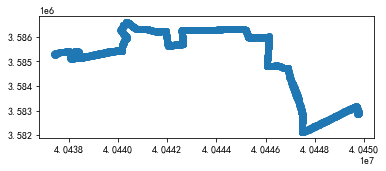

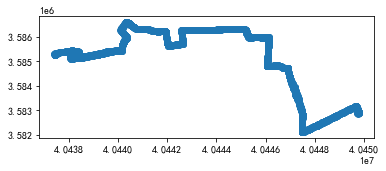

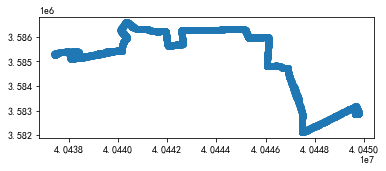

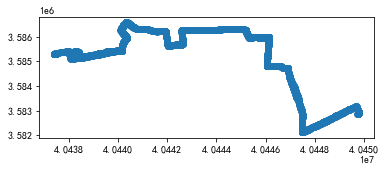

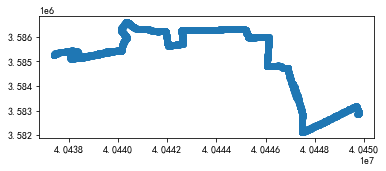

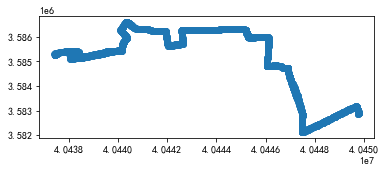

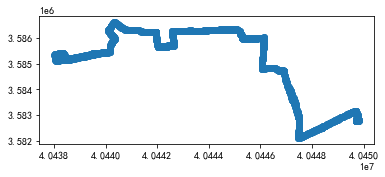

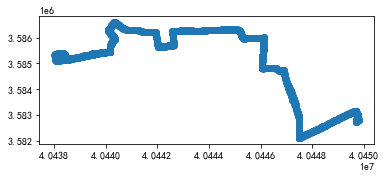

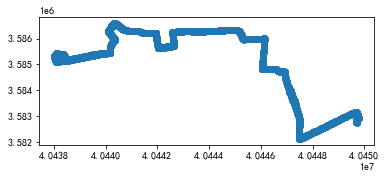

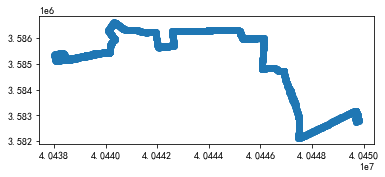

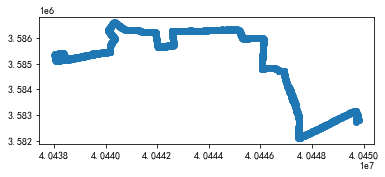

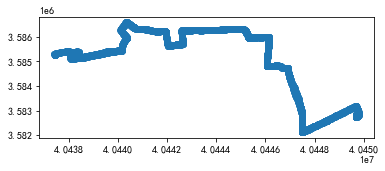

In [24]:
##线路核查
cheid2=[]
for cheid in files['文件']:
    #读取GPS数据
    BUS_GPS= pd.read_csv(r'D:\项目\扬州\BUSGPS\车辆编号带线路编号\\'+str(cheid)+'_'+str(routeid)+'.csv',header = None)
    print('len(BUS_GPS)')
    print(len(BUS_GPS))
    if len(BUS_GPS)>10:
        ##提取有用BUS_GPS
        BUS_GPS.columns=BUS_GPS.iloc[0]
        BUS_GPS=BUS_GPS[BUS_GPS['???"BUSRDID"']!='???"BUSRDID"']
        BUS_GPS=BUS_GPS[[ '???"BUSRDID"', 'ROUTEID', 'PRODUCTID', 'ACTDATETIME', 'BUSSID', 'LONGITUDE', 'LATITUDE']]
        ###切分字符串，对BUS_GPS进行进一步处理
        BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/12']
        BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/13']
        BUS_GPS=BUS_GPS.loc[BUS_GPS.ACTDATETIME!='2021/5/14']
        #print(BUS_GPS)
        BUS_GPS['日期'] = BUS_GPS['ACTDATETIME'].apply(lambda r:r.split(' ')[0])
        BUS_GPS['时间'] = BUS_GPS['ACTDATETIME'].apply(lambda r:r.split(' ')[1])
        BUS_GPS=BUS_GPS.loc[BUS_GPS.日期=='2021/5/13']
        if len(BUS_GPS)>100:
            ##切分bus_gps的车辆编号
            BUS_GPS['PRODUCTID']= BUS_GPS['PRODUCTID'].astype(str)
            BUS_GPS['carid'] = BUS_GPS['PRODUCTID'].apply(lambda r:r.split('5140')[1])
            BUS_GPS['time_st'] = BUS_GPS['时间'].apply(lambda r:r.split(':')[0]).astype('int')*3600+\
                            BUS_GPS['时间'].apply(lambda r:r.split(':')[1]).astype('int')*60+\
                            BUS_GPS['时间'].apply(lambda r:r.split(':')[2]).astype('int')
            BUS_GPS.sort_values(by='time_st',inplace=True)
            ##BUS_GPS[BUS_GPS['BUSSID']=='4.0']观察数据，bussid 4下行5上行6环形
            ###生成BUS_GPS的点要素
            #对公交GPS点生成点要素，并转换为一个GeoDataFrame，方便后续的地图匹配
            BUS_GPS[['ROUTEID','LONGITUDE','LATITUDE']]= BUS_GPS[['ROUTEID','LONGITUDE','LATITUDE']].apply(pd.to_numeric)###字符串转换为数值
            print(BUS_GPS)
            BUS_GPS['geometry'] = BUS_GPS.apply(lambda r:Point(r['LONGITUDE'],r['LATITUDE']),axis = 1)
            BUS_GPS = gpd.GeoDataFrame(BUS_GPS)##转换为一个GeoDataFrame
            BUS_GPS
            xianluid=BUS_GPS['ROUTEID'].iloc[0]
            print('xianluid')
            print(xianluid)
            ##GeoDataFrame坐标转换
            BUS_GPS.crs = {'init':'epsg:4326'}
            BUS_GPS = BUS_GPS.to_crs(epsg = 2416)
            BUS_GPS###至此公交车数据预处理完毕
            ###清除飘零点
            BUS_GPS=BUS_GPS[(BUS_GPS['LONGITUDE']!=0)&(BUS_GPS['LATITUDE']!=0)]
            ###清除不动点
            BUS_GPS['LONGITUDE1'] = BUS_GPS['LONGITUDE'].shift(-1)
            BUS_GPS['不动点']=BUS_GPS['LONGITUDE1']-BUS_GPS['LONGITUDE']
            qq=BUS_GPS['不动点'].unique()
            print(len(qq))
            if len(qq)>100:
                if len(BUS_GPS)>500:
                    BUS_GPS.plot()
                    #地图匹配
                    BUS_GPS['project'] = BUS_GPS['geometry'].apply(lambda r:lineshp.project(r))
                    #原始的坐标点存储在一个字段中
                    BUS_GPS['geometry_orgin'] = BUS_GPS['geometry']
                    #生成匹配的坐标点
                    BUS_GPS['geometry'] = BUS_GPS['project'].apply(lambda r:lineshp.interpolate(r))
                    #批量计算原始点和匹配点之间的距离
                    BUS_GPS['diff'] = BUS_GPS.apply(lambda r:r['geometry_orgin'].distance(r['geometry']),axis = 1)
                    ##轨迹点偏移shp400米以外，则删除
                    BUS_GPS=BUS_GPS[BUS_GPS['diff']<1000]
                    cheid2.append(cheid)
print(cheid2)

##若轨迹不连续，则读取一辆车的单趟轨迹作为lineshp，如果含往返会出问题
line=pd.read_csv(r'F:\扬州公交GPS数据\扬州公交\line_5_6\线路shp\\'+str(xianluid)+'_line.csv')
#生成线要素
from shapely.geometry import LineString
dianlon=line['LONGITUDE']
dianlat=line['LATITUDE']
dianlist=[]
for i in range(0,len(line)):
    g=(dianlon[i],dianlat[i])
    dianlist.append(g)
    pass
dianlist
linestr = LineString(dianlist)
line['geometry']=linestr
line = gpd.GeoDataFrame(line)
line.crs = {'init':'epsg:4326'}
line=line.to_crs(epsg = 2416)
lineshp=line['geometry'].iloc[0]
lineshp

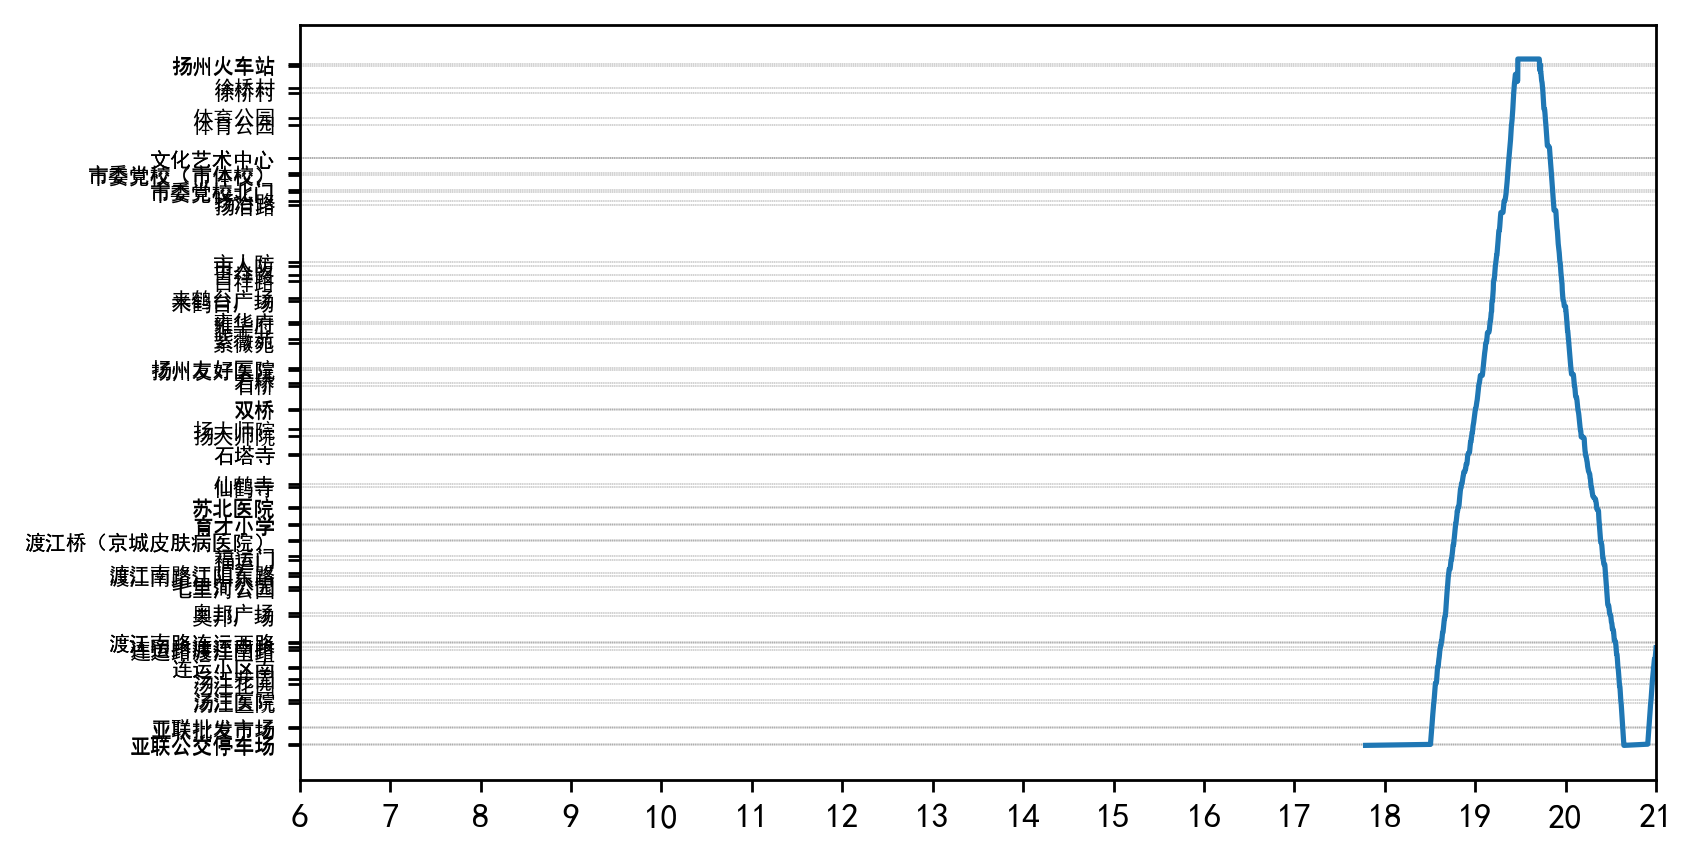

In [27]:
##单车运行图
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
fig     = plt.figure(1,(7,4),dpi = 250)    
ax1      = plt.subplot(111)
tmp=BUS_project
#灰色线标注站点位置
for i in range(len(stop)):
    project = stop['project'].iloc[i]
    stopname = stop['STATIONNAME'].iloc[i]
    plt.plot([0,24*3600],[project,project],'k--',lw=0.1)
    
plt.plot(tmp['time_st'],tmp['project'])

plt.xticks(range(0,24*3600+1,3600),range(24+1))

#标记站点名字
plt.yticks(stop['project'],stop['STATIONNAME'],size = 6)

plt.xlim(6*3600,21*3600)
plt.show()

##全显示不折叠，非常耗内存，非特殊情况不要生效
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
ls2